# Predicting NDVI and Height from Pasture Images

This notebook explores whether we can predict `Pre_GSHH_NDVI` and `Height_Ave_cm` from the pasture images using lightweight image models.

In [12]:
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import timm
from tqdm.auto import tqdm

from models import CenterCrop, UnifiedModel
from utils import MODEL_CONFIGS

# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 1. Load and Explore the Data

In [13]:
# Load training data
train_df = pd.read_csv("../data/train.csv")

# Get unique images with their metadata (each image has 5 rows, one per target)
metadata_df = train_df.drop_duplicates(subset=["image_path"])[
    ["image_path", "Pre_GSHH_NDVI", "Height_Ave_cm", "State", "Species"]
].reset_index(drop=True)

print(f"Total unique images: {len(metadata_df)}")
metadata_df.head()

Total unique images: 357


,image_path,Pre_GSHH_NDVI,Height_Ave_cm,State,Species
0,train/ID1011485656.jpg,0.62,4.6667,Tas,Ryegrass_Clover
1,train/ID1012260530.jpg,0.55,16.0000,NSW,Lucerne
2,train/ID1025234388.jpg,0.38,1.0000,WA,SubcloverDalkeith
3,train/ID1028611175.jpg,0.66,5.0000,Tas,Ryegrass
4,train/ID1035947949.jpg,0.54,3.5000,Tas,Ryegrass


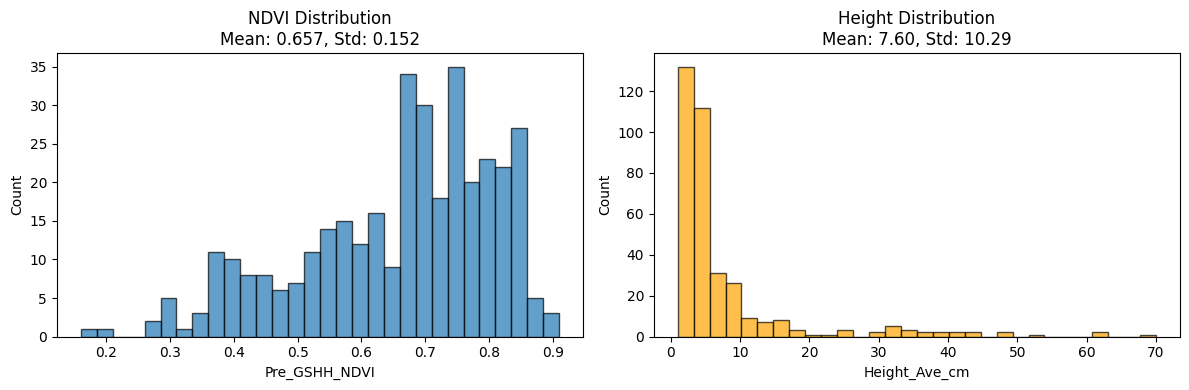

In [14]:
# Explore target distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(metadata_df["Pre_GSHH_NDVI"], bins=30, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Pre_GSHH_NDVI")
axes[0].set_ylabel("Count")
axes[0].set_title(
    f"NDVI Distribution\nMean: {metadata_df['Pre_GSHH_NDVI'].mean():.3f}, Std: {metadata_df['Pre_GSHH_NDVI'].std():.3f}"
)

axes[1].hist(
    metadata_df["Height_Ave_cm"], bins=30, edgecolor="black", alpha=0.7, color="orange"
)
axes[1].set_xlabel("Height_Ave_cm")
axes[1].set_ylabel("Count")
axes[1].set_title(
    f"Height Distribution\nMean: {metadata_df['Height_Ave_cm'].mean():.2f}, Std: {metadata_df['Height_Ave_cm'].std():.2f}"
)

plt.tight_layout()
plt.show()

In [15]:
# Check for missing values
print("Missing values:")
print(metadata_df[["Pre_GSHH_NDVI", "Height_Ave_cm"]].isna().sum())

# Basic statistics
print("\nStatistics:")
metadata_df[["Pre_GSHH_NDVI", "Height_Ave_cm"]].describe()

Missing values:
Pre_GSHH_NDVI    0
Height_Ave_cm    0
dtype: int64

Statistics:


,Pre_GSHH_NDVI,Height_Ave_cm
count,357.000000,357.000000
mean,0.657423,7.595985
std,0.152142,10.285262
min,0.160000,1.000000
25%,0.560000,3.000000
50%,0.690000,4.000000
75%,0.770000,7.000000
max,0.910000,70.000000


## 2. Create Custom Dataset

In [16]:
class MetadataDataset(Dataset):
    """Dataset for predicting NDVI and Height from images."""

    def __init__(self, df: pd.DataFrame, img_dir: str, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

        # Normalize targets for better training
        self.ndvi_mean = df["Pre_GSHH_NDVI"].mean()
        self.ndvi_std = df["Pre_GSHH_NDVI"].std()
        self.height_mean = df["Height_Ave_cm"].mean()
        self.height_std = df["Height_Ave_cm"].std()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        img_path = os.path.join(self.img_dir, os.path.basename(row["image_path"]))
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Get normalized targets
        ndvi = (row["Pre_GSHH_NDVI"] - self.ndvi_mean) / self.ndvi_std
        height = (row["Height_Ave_cm"] - self.height_mean) / self.height_std

        targets = torch.tensor([ndvi, height], dtype=torch.float32)
        return image, targets

    def denormalize_predictions(self, preds):
        """Convert normalized predictions back to original scale."""
        ndvi = preds[:, 0] * self.ndvi_std + self.ndvi_mean
        height = preds[:, 1] * self.height_std + self.height_mean
        return torch.stack([ndvi, height], dim=1)

## 3. Define Lightweight Model

In [17]:
class MetadataPredictor(nn.Module):
    """Model to predict NDVI and Height from images."""

    def __init__(self, model_name: str, pretrained: bool = True):
        super().__init__()
        self.model_name = model_name

        # Create backbone without classification head
        self.backbone = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0
        )

        # Get feature dimension
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            feat_dim = self.backbone(dummy).shape[-1]

        # Simple regression head for 2 outputs
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2),  # NDVI and Height
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

## 4. Training Functions

In [18]:
def get_transforms(model_name: str, image_size: int = 224):
    """Get transforms based on model type."""
    from torchvision import transforms

    if "vit" in model_name.lower() and "dinov2" not in model_name.lower():
        mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
    else:
        mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

    return transforms.Compose(
        [
            CenterCrop(500, 1500),  # Crop center of 2000x1000 image
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    )


def compute_r2(y_true, y_pred):
    """Compute R2 score."""
    ss_res = ((y_true - y_pred) ** 2).sum(dim=0)
    ss_tot = ((y_true - y_true.mean(dim=0)) ** 2).sum(dim=0)
    r2 = 1 - ss_res / (ss_tot + 1e-8)
    return r2


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for images, targets in dataloader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * images.size(0)
            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    r2_scores = compute_r2(all_targets, all_preds)

    return total_loss / len(dataloader.dataset), r2_scores, all_preds, all_targets

In [19]:
def train_model(
    model_name: str, train_loader, val_loader, n_epochs: int = 20, lr: float = 1e-4
):
    """Train a model and return training history."""
    print(f"\n{'=' * 50}")
    print(f"Training: {model_name}")
    print(f"{'=' * 50}")

    model = MetadataPredictor(model_name).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    criterion = nn.MSELoss()

    history = {
        "train_loss": [],
        "val_loss": [],
        "r2_ndvi": [],
        "r2_height": [],
    }

    best_val_loss = float("inf")
    patience_counter = 0
    patience = 5

    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, r2_scores, _, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["r2_ndvi"].append(r2_scores[0].item())
        history["r2_height"].append(r2_scores[1].item())

        print(
            f"Epoch {epoch + 1:2d}/{n_epochs} | "
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
            f"R2 NDVI: {r2_scores[0]:.4f} | R2 Height: {r2_scores[1]:.4f}"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Final evaluation
    _, r2_final, preds, targets = evaluate(model, val_loader, criterion, device)

    return model, history, preds, targets

## 5. Prepare Data and Train Models

In [20]:
# Models to compare (lightweight models)
MODELS_TO_TEST = [
    # "resnet18",
    # "mobilenetv3_small_100",
    # "efficientnet_b0",
    "vit_tiny_patch16_224",
]

# Training settings
N_EPOCHS = 15
BATCH_SIZE = 16
LR = 1e-4
TRAIN_SPLIT = 0.8

In [22]:
# Create dataset with transforms for the first model (will recreate for each)
img_dir = "../data/train"

# Store results for all models
all_results = {}

for model_name in MODELS_TO_TEST:
    # Get appropriate transforms
    transform = get_transforms(model_name)

    # Create dataset
    dataset = MetadataDataset(metadata_df, img_dir, transform=transform)

    # Split dataset
    train_size = int(TRAIN_SPLIT * len(dataset))
    val_size = len(dataset) - train_size

    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], generator=generator
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
    )

    # Train model
    model, history, preds, targets = train_model(
        model_name, train_loader, val_loader, n_epochs=N_EPOCHS, lr=LR
    )

    # Store results
    all_results[model_name] = {
        "history": history,
        "preds": preds,
        "targets": targets,
        "dataset": dataset,  # For denormalization
    }


Training: vit_tiny_patch16_224
Epoch  1/15 | Train Loss: 0.9022 | Val Loss: 0.3289 | R2 NDVI: 0.7601 | R2 Height: 0.3217
Epoch  2/15 | Train Loss: 0.3421 | Val Loss: 0.2203 | R2 NDVI: 0.6984 | R2 Height: 0.8056
Epoch  3/15 | Train Loss: 0.2072 | Val Loss: 0.1279 | R2 NDVI: 0.8669 | R2 Height: 0.8097
Epoch  4/15 | Train Loss: 0.1540 | Val Loss: 0.1269 | R2 NDVI: 0.8810 | R2 Height: 0.7872
Epoch  5/15 | Train Loss: 0.1432 | Val Loss: 0.0973 | R2 NDVI: 0.8991 | R2 Height: 0.8545
Epoch  6/15 | Train Loss: 0.1281 | Val Loss: 0.1353 | R2 NDVI: 0.8748 | R2 Height: 0.7699
Epoch  7/15 | Train Loss: 0.1034 | Val Loss: 0.1171 | R2 NDVI: 0.8988 | R2 Height: 0.7876
Epoch  8/15 | Train Loss: 0.1045 | Val Loss: 0.0992 | R2 NDVI: 0.8942 | R2 Height: 0.8571
Epoch  9/15 | Train Loss: 0.0770 | Val Loss: 0.1143 | R2 NDVI: 0.9025 | R2 Height: 0.7903
Epoch 10/15 | Train Loss: 0.0787 | Val Loss: 0.0944 | R2 NDVI: 0.9054 | R2 Height: 0.8527
Epoch 11/15 | Train Loss: 0.0656 | Val Loss: 0.0883 | R2 NDVI: 0.907

## 6. Plot Training Results

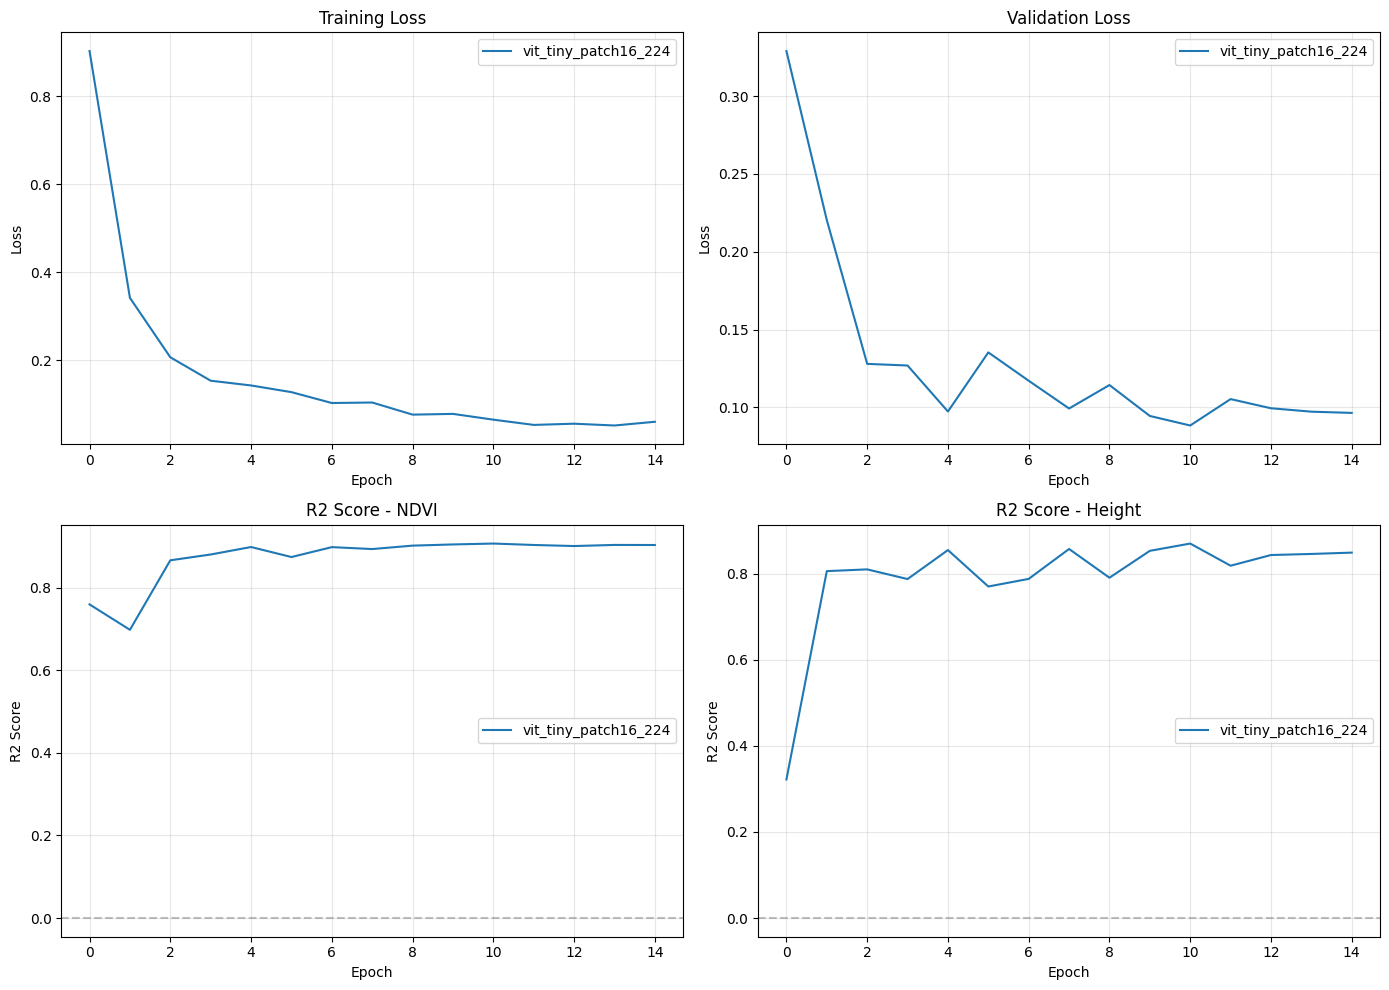

In [23]:
# Plot training curves for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(MODELS_TO_TEST)))

# Training Loss
ax = axes[0, 0]
for (model_name, results), color in zip(all_results.items(), colors):
    ax.plot(results["history"]["train_loss"], label=model_name, color=color)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss")
ax.legend()
ax.grid(True, alpha=0.3)

# Validation Loss
ax = axes[0, 1]
for (model_name, results), color in zip(all_results.items(), colors):
    ax.plot(results["history"]["val_loss"], label=model_name, color=color)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Validation Loss")
ax.legend()
ax.grid(True, alpha=0.3)

# R2 NDVI
ax = axes[1, 0]
for (model_name, results), color in zip(all_results.items(), colors):
    ax.plot(results["history"]["r2_ndvi"], label=model_name, color=color)
ax.set_xlabel("Epoch")
ax.set_ylabel("R2 Score")
ax.set_title("R2 Score - NDVI")
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

# R2 Height
ax = axes[1, 1]
for (model_name, results), color in zip(all_results.items(), colors):
    ax.plot(results["history"]["r2_height"], label=model_name, color=color)
ax.set_xlabel("Epoch")
ax.set_ylabel("R2 Score")
ax.set_title("R2 Score - Height")
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/metadata_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

In [24]:
# Summary table of final metrics
summary_data = []
for model_name, results in all_results.items():
    summary_data.append(
        {
            "Model": model_name,
            "Final Val Loss": results["history"]["val_loss"][-1],
            "Best Val Loss": min(results["history"]["val_loss"]),
            "Final R2 NDVI": results["history"]["r2_ndvi"][-1],
            "Final R2 Height": results["history"]["r2_height"][-1],
            "Best R2 NDVI": max(results["history"]["r2_ndvi"]),
            "Best R2 Height": max(results["history"]["r2_height"]),
        }
    )

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Best Val Loss")
print("\nModel Comparison Summary:")
summary_df


Model Comparison Summary:


,Model,Final Val Loss,Best Val Loss,Final R2 NDVI,Final R2 Height,Best R2 NDVI,Best R2 Height
0,vit_tiny_patch16_224,0.096419,0.088325,0.903973,0.848582,0.907507,0.869652


## 7. Scatter Plots: Actual vs Predicted

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

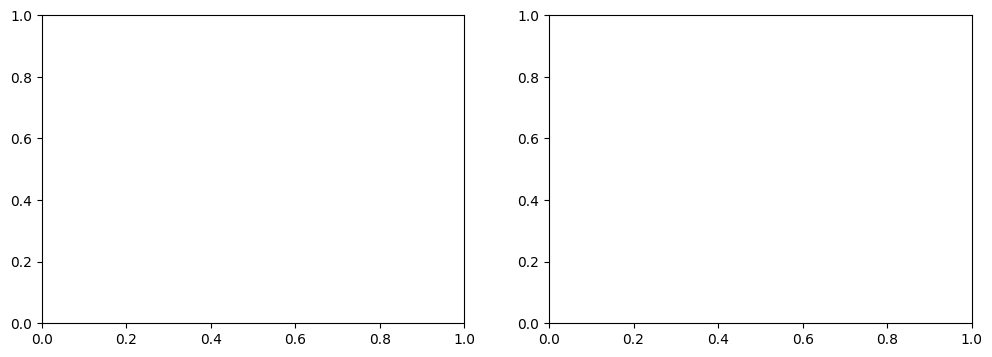

In [25]:
# Create scatter plots for each model
fig, axes = plt.subplots(len(MODELS_TO_TEST), 2, figsize=(12, 4 * len(MODELS_TO_TEST)))

for i, (model_name, results) in enumerate(all_results.items()):
    preds = results["preds"]
    targets = results["targets"]
    dataset = results["dataset"]

    # Denormalize
    preds_denorm = dataset.denormalize_predictions(preds)
    targets_denorm = dataset.denormalize_predictions(targets)

    # NDVI scatter
    ax = axes[i, 0]
    ax.scatter(
        targets_denorm[:, 0],
        preds_denorm[:, 0],
        alpha=0.6,
        edgecolors="black",
        linewidth=0.5,
    )
    min_val = min(targets_denorm[:, 0].min(), preds_denorm[:, 0].min())
    max_val = max(targets_denorm[:, 0].max(), preds_denorm[:, 0].max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect")
    ax.set_xlabel("Actual NDVI")
    ax.set_ylabel("Predicted NDVI")
    ax.set_title(f"{model_name} - NDVI (R2: {results['history']['r2_ndvi'][-1]:.3f})")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Height scatter
    ax = axes[i, 1]
    ax.scatter(
        targets_denorm[:, 1],
        preds_denorm[:, 1],
        alpha=0.6,
        edgecolors="black",
        linewidth=0.5,
        color="orange",
    )
    min_val = min(targets_denorm[:, 1].min(), preds_denorm[:, 1].min())
    max_val = max(targets_denorm[:, 1].max(), preds_denorm[:, 1].max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2, label="Perfect")
    ax.set_xlabel("Actual Height (cm)")
    ax.set_ylabel("Predicted Height (cm)")
    ax.set_title(
        f"{model_name} - Height (R2: {results['history']['r2_height'][-1]:.3f})"
    )
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/metadata_scatter_plots.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Final Comparison Bar Plot

In [ ]:
# Bar plot comparing best R2 scores across models
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(MODELS_TO_TEST))
width = 0.35

r2_ndvi = [all_results[m]["history"]["r2_ndvi"][-1] for m in MODELS_TO_TEST]
r2_height = [all_results[m]["history"]["r2_height"][-1] for m in MODELS_TO_TEST]

bars1 = ax.bar(
    x - width / 2, r2_ndvi, width, label="NDVI", color="steelblue", edgecolor="black"
)
bars2 = ax.bar(
    x + width / 2, r2_height, width, label="Height", color="coral", edgecolor="black"
)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(
        f"{height:.3f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
    )
for bar in bars2:
    height = bar.get_height()
    ax.annotate(
        f"{height:.3f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_ylabel("R2 Score")
ax.set_title("Model Comparison: R2 Scores for NDVI and Height Prediction")
ax.set_xticks(x)
ax.set_xticklabels(MODELS_TO_TEST, rotation=15, ha="right")
ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("../results/metadata_model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

## 9. Conclusions

Key observations from this experiment:

1. **NDVI Prediction**: NDVI (Normalized Difference Vegetation Index) measures greenness/vegetation health. The ability to predict this from images suggests the models can learn color-based features related to vegetation density.

2. **Height Prediction**: Height is more challenging as it requires understanding 3D structure from 2D top-down images. This is inherently difficult without depth information.

3. **Model Comparison**: Compare which models perform best on each task - this can inform feature extraction choices for the main biomass prediction task.

4. **Potential Use**: These predicted features could potentially be used as additional inputs to the main biomass prediction model, or the models themselves could be used as feature extractors.

## 10. Save and Upload ViT-Tiny Model

In [ ]:
# Re-train the best model (vit_tiny) to get a fresh reference
# (since the loop overwrote the model variable, we need to recreate it)

best_model_name = "vit_tiny_patch16_224"
transform = get_transforms(best_model_name)
dataset = MetadataDataset(metadata_df, img_dir, transform=transform)

train_size = int(TRAIN_SPLIT * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    dataset, [train_size, val_size], generator=generator
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# Train final model
vit_model, _, _, _ = train_model(
    best_model_name, train_loader, val_loader, n_epochs=N_EPOCHS, lr=LR
)

# Store normalization stats with the model for inference
model_metadata = {
    "ndvi_mean": dataset.ndvi_mean,
    "ndvi_std": dataset.ndvi_std,
    "height_mean": dataset.height_mean,
    "height_std": dataset.height_std,
}


Training: vit_tiny_patch16_224


Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=99, pipe_handle=276)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.14/3.14.2/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.14/3.14.2/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: module '__main__' has no attribute 'MetadataDataset'
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=99, pipe_handle=269)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/hom

RuntimeError: DataLoader worker (pid(s) 9466) exited unexpectedly

In [ ]:
# Save model locally with TorchScript for portability
import wandb
import kagglehub

MODEL_SAVE_PATH = "../models/vit-tiny-height-ndvi.pt"

# Move to CPU for saving
vit_model_cpu = vit_model.to("cpu")
vit_model_cpu.eval()

# Create example input for tracing
example_input = torch.randn(1, 3, 224, 224)

# Trace and save as TorchScript
traced_model = torch.jit.trace(vit_model_cpu, example_input)
torch.jit.save(traced_model, MODEL_SAVE_PATH)

# Also save metadata separately
torch.save(model_metadata, "../models/vit-tiny-height-ndvi-metadata.pt")

print(f"Model saved to: {MODEL_SAVE_PATH}")
print(f"Metadata: {model_metadata}")

In [ ]:
# Upload to Weights & Biases
with wandb.init(
    project="image2biomass", job_type="model-upload", name="vit-tiny-height-ndvi"
) as run:
    # Create artifact
    artifact = wandb.Artifact(
        name="vit-tiny-height-ndvi",
        type="model",
        description="ViT-Tiny model trained to predict NDVI and Height from pasture images",
        metadata={
            "model_name": "vit_tiny_patch16_224",
            "targets": ["Pre_GSHH_NDVI", "Height_Ave_cm"],
            "image_size": 224,
            "normalization": "vit",  # mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
            **model_metadata,
        },
    )

    # Add model files
    artifact.add_file(MODEL_SAVE_PATH)
    artifact.add_file("../models/vit-tiny-height-ndvi-metadata.pt")

    # Log artifact
    run.log_artifact(artifact)
    print("Model uploaded to W&B successfully!")

In [ ]:
# Upload to Kaggle as a private dataset
# Note: Requires kaggle credentials configured (~/.kaggle/kaggle.json)

import shutil
import json

# Create a temp directory with model files for Kaggle upload
kaggle_model_dir = "../models/kaggle-upload-temp"
os.makedirs(kaggle_model_dir, exist_ok=True)

# Copy model files
shutil.copy(MODEL_SAVE_PATH, kaggle_model_dir)
shutil.copy("../models/vit-tiny-height-ndvi-metadata.pt", kaggle_model_dir)

# Create dataset metadata
dataset_metadata = {
    "title": "vit-tiny-height-ndvi",
    "id": "matthieuneau/vit-tiny-height-ndvi",
    "licenses": [{"name": "CC0-1.0"}],
}

with open(os.path.join(kaggle_model_dir, "dataset-metadata.json"), "w") as f:
    json.dump(dataset_metadata, f)

# Upload using kagglehub
kagglehub.dataset_upload(
    handle="matthieuneau/vit-tiny-height-ndvi",
    local_dataset_dir=kaggle_model_dir,
    version_notes="ViT-Tiny model for NDVI and Height prediction from pasture images",
)

# Cleanup temp directory
shutil.rmtree(kaggle_model_dir)
print("Model uploaded to Kaggle successfully!")